# Quadratic Programming

In [1]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


In [2]:
using Pkg
Pkg.activate("../..")
Pkg.status()

 Activating environment at `~/Dropbox/class/M1399.000200/2020/Project.toml`


Status `~/Dropbox/class/M1399.000200/2020/Project.toml`
  [7d9fca2a] Arpack v0.4.0
  [6e4b80f9] BenchmarkTools v0.5.0
  [1e616198] COSMO v0.7.7
  [f65535da] Convex v0.13.7
  [31c24e10] Distributions v0.23.12
  [f6369f11] ForwardDiff v0.10.12
  [c91e804a] Gadfly v1.3.1
  [bd48cda9] GraphRecipes v0.5.4
  [2e9cd046] Gurobi v0.9.2
  [82e4d734] ImageIO v0.3.1
  [6218d12a] ImageMagick v1.1.6
  [916415d5] Images v0.23.1
  [b6b21f68] Ipopt v0.6.3
  [42fd0dbc] IterativeSolvers v0.8.4
  [4076af6c] JuMP v0.21.4
  [b51810bb] MatrixDepot v0.9.0-DEV #master (https://github.com/JuliaMatrices/MatrixDepot.jl.git)
  [6405355b] Mosek v1.1.3
  [1ec41992] MosekTools v0.9.4
  [76087f3c] NLopt v0.6.1
  [47be7bcc] ORCA v0.5.0
  [a03496cd] PlotlyBase v0.4.1
  [f0f68f2c] PlotlyJS v0.14.0
  [91a5bcdd] Plots v1.6.12
  [438e738f] PyCall v1.92.1
  [d330b81b] PyPlot v2.9.0
  [dca85d43] QuartzImageIO v0.7.3
  [6f49c342] RCall v0.13.9
  [c946c3f1] SCS v0.7.1
  [276daf66] SpecialFunctions v0.10.3
  [2913bbd2] StatsBase

## Quadratic programming (QP)

<img src="./qp.png" width="500"/>

* A (linearly constrained) **quadratic program** (QP) has quadratic objective function and affine constraint functions
\begin{eqnarray*}
	&\text{minimize}& (1/2) \mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} + r \\
	&\text{subject to}& \mathbf{G} \mathbf{x} \leq \mathbf{h} \\
	& & \mathbf{A} \mathbf{x} = \mathbf{b},
\end{eqnarray*}
where we require $\mathbf{P} \in \mathbb{S}_+^d$ (why?). Apparently LP is a special case of QP with $\mathbf{P} = \mathbf{0}_{n \times n}$.

## QP examples 1: least squares

* The _least squares_ problem minimizes $\|\mathbf{y} - \mathbf{X} \beta\|_2^2$, which obviously is an (unconstrained) QP.

* Ridge regression.

## QP examples 2: constrained least squares

* Least squares with linear constraints. For example, _nonnegative least squares_ (NLS)
\begin{eqnarray*}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \mathbf{X} \beta\|_2^2 \\
	&\text{subject to}& \beta \geq \mathbf{0}.
\end{eqnarray*}    

## QP example 3: lasso

* Lasso regression [Tibshirani (1996)](https://www.jstor.org/stable/2346178), [Donoho (1994)](https://doi.org/10.1093/biomet/81.3.425) minimizes the least squares loss with $\ell_1$ (lasso) penalty
\begin{eqnarray*}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1,
\end{eqnarray*}
where $\lambda \ge 0$ is a tuning parameter. Writing $\beta = \beta^+ - \beta^-$, the equivalent QP is
\begin{eqnarray*}
	&\text{minimize}& \frac 12 (\beta^+ - \beta^-)^T \mathbf{X}^T \left(\mathbf{I} - \frac{\mathbf{1} \mathbf{1}^T}{n} \right) \mathbf{X} (\beta^+ - \beta^-) + \\
	& & \quad \mathbf{y}^T \left(\mathbf{I} - \frac{\mathbf{1} \mathbf{1}^T}{n} \right) \mathbf{X} (\beta^+ - \beta^-) + \lambda \mathbf{1}^T (\beta^+ + \beta^-) \\
	&\text{subject to}& \beta^+ \succeq \mathbf{0}, \, \beta^- \succeq \mathbf{0}
\end{eqnarray*}
in $\beta^+$ and $\beta^-$.

## QP example 4: elastic net

* Elastic net [Zou and Hastie (2005)](https://www.jstor.org/stable/3647580)
\begin{eqnarray*}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1}  - \mathbf{X} \beta\|_2^2 + \lambda (\alpha \|\beta\|_1 + (1-\alpha) \|\beta\|_2^2),
\end{eqnarray*}
where $\lambda \ge 0$ and $\alpha \in [0,1]$ are tuning parameters.

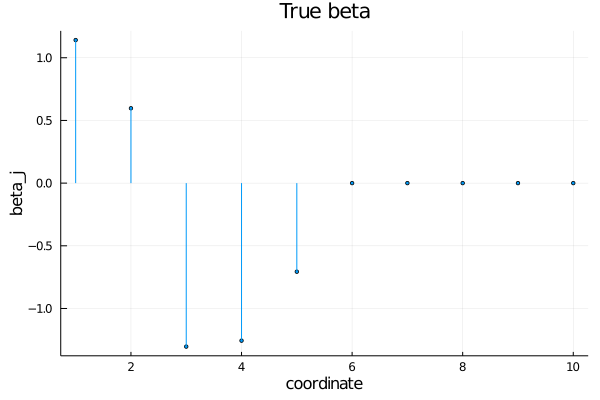

In [3]:
using Random, LinearAlgebra, SparseArrays

Random.seed!(123) # seed

n, p = 100, 10
# Design matrix
X = [ones(n, 1) randn(n, p)]
# True regression coefficients (first 5 are non-zero)
β = [1.0; randn(5); zeros(p - 5)]
# Responses
y = X * β + randn(n)

# plot the true β
using Plots; gr()

plt = plot(1:p, β[2:end], line=:stem, marker=2, legend=:none)
xlabel!(plt, "coordinate")
ylabel!(plt, "beta_j")
title!(plt, "True beta")

  0.420452 seconds (658.54 k allocations: 35.925 MiB)


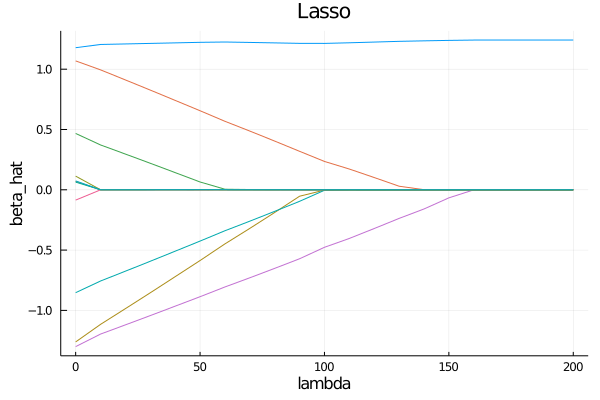

In [14]:
using Convex

## Use Mosek solver
#using Mosek, MosekTools
#opt = () -> Mosek.Optimizer(LOG=0)

## Use SCS solver
#using SCS
#opt = () -> SCS.Optimizer(verbose=0)  

# Use COSMO solver
using COSMO
opt = () -> COSMO.Optimizer(max_iter=10000, verbose=false) 

# solve at a grid of λ
λgrid = 0:10:200
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂lasso = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂lasso) + λ * norm(β̂lasso[2:end], 1))
    solve!(problem, opt)
    β̂path[i, :] = β̂lasso.value
end

plt = plot(collect(λgrid), β̂path, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Lasso")

┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252
┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution

  1.903110 seconds (3.79 M allocations: 184.783 MiB, 4.46% gc time)


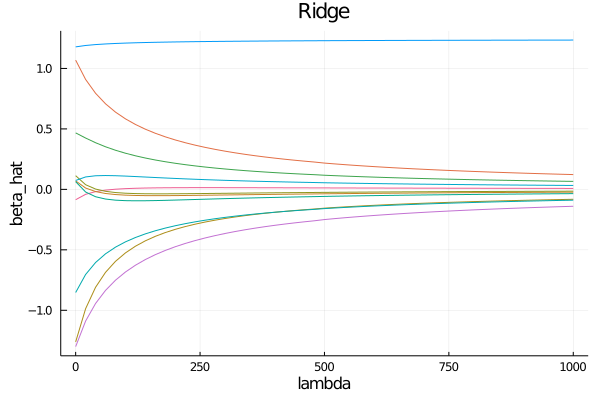

In [15]:
# solve at a grid of λ
λgrid = 0:20:1000
ridgepath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂ridge = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(sumsquares(y - X * β̂ridge) + λ * sumsquares(β̂ridge[2:end]))
    solve!(problem, opt)
    ridgepath[i, :] = β̂ridge.value
end

plt = plot(collect(λgrid), ridgepath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Ridge")

  1.283118 seconds (2.53 M allocations: 120.877 MiB, 2.76% gc time)


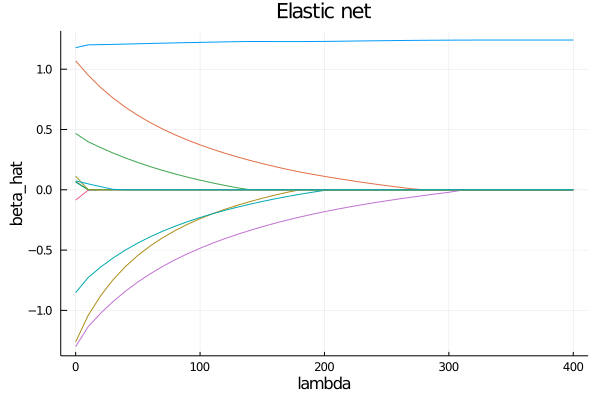

In [16]:
# solve at a grid of λ
λgrid = 0:10:400
alpha = 0.5
elastipath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂elastic = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5*sumsquares(y - X * β̂elastic) + 
        λ * (alpha*norm(β̂elastic[2:end],1) + (1-alpha)*sumsquares(β̂elastic[2:end])))
    solve!(problem, opt)
    elastipath[i, :] = β̂elastic.value
end

plt = plot(collect(λgrid), elastipath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Elastic net")

## QP example 5: constrained lasso

* (Linearly) constrained lasso
\begin{eqnarray*}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1 \\
	&\text{subject to}& \mathbf{G} \beta \leq \mathbf{h} \\
	& & \mathbf{A} \beta = \mathbf{b},
\end{eqnarray*}
where $\lambda \ge 0$ is a tuning parameter. 

* We have seen this example (zero-sum lasso) before.

## QP example 7: robust regression

* The Huber loss function 
\begin{eqnarray*}
	\phi(r) = \begin{cases}
	r^2 & |r| \le M \\
	M(2|r| - M) & |r| > M
	\end{cases}
\end{eqnarray*}
is commonly used in robust statistics. The robust regression problem
\begin{eqnarray*}
	&\text{minimize}& \sum_{i=1}^n \phi(y_i - \beta_0 - \mathbf{x}_i^T \beta)
\end{eqnarray*}
can be transformed to a QP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{u}^T \mathbf{u} + 2 M \mathbf{1}^T \mathbf{v} \\
	&\text{subject to}& - \mathbf{u} - \mathbf{v} \leq \mathbf{y} - \mathbf{X} \beta \leq \mathbf{u} + \mathbf{v} \\
	& & \mathbf{0} \preceq \mathbf{u} \leq M \mathbf{1}, \mathbf{v} \geq \mathbf{0}
\end{eqnarray*}
in $\mathbf{u}, \mathbf{v} \in \mathbb{R}^n$ and $\beta \in \mathbb{R}^p$. Hint: write $|r_i| = (|r_i| \wedge M) + (|r_i| - M)_+ = u_i + v_i$.

<img src="./Huber-loss.png" width="500"/>

## QP example 8: SVM

* In two-class classification problems, we are given training data $(\mathbf{x}_i, y_i)$, $i=1,\ldots,n$, where $\mathbf{x}_i \in \mathbb{R}^n$ are feature vector and $y_i \in \{-1, 1\}$ are class labels. Support vector machine (SVM) solves the optimization problem
\begin{eqnarray*}
	&\text{minimize}& \sum_{i=1}^n \left[ 1 - y_i \left( \beta_0 + \sum_{j=1}^p x_{ij} \beta_j \right) \right]_+ + \lambda \|\beta\|_2^2,
\end{eqnarray*}
where $\lambda \ge 0$ is a tuning parameters. This is a QP (why?).

  1.861471 seconds (5.99 M allocations: 305.816 MiB, 4.68% gc time)


┌ Warning: Problem status ITERATION_LIMIT; solution may be inaccurate.
└ @ Convex /Users/jhwon/.julia/packages/Convex/aYxJA/src/solution.jl:252


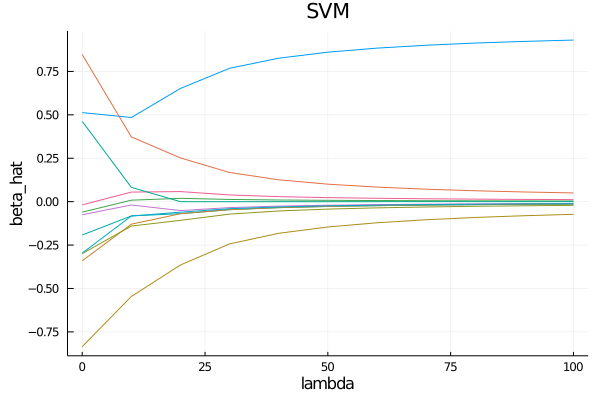

In [17]:
# convert to classification problem
Y = sign.(X * β + 5 * randn(n))

# solve at a grid of λ
λgrid = 0:10:100
β̂svmpath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂svm = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(sum(pos(1 - Y .* (X * β̂svm))) + λ * sumsquares(β̂svm[2:end]))
    solve!(problem, opt)
    β̂svmpath[i, :] = β̂svm.value
end

plt = plot(collect(λgrid), β̂svmpath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "SVM")
    

## Acknowledgment

Many parts of this lecture note is based on [Dr. Hua Zhou](http://hua-zhou.github.io)'s 2019 Spring Statistical Computing course notes available at <http://hua-zhou.github.io/teaching/biostatm280-2019spring/index.html>.